# Extract SAR Amplitude time series

This notebook extracts a time series from a collection of GeoTiff files. A map is presented where you can select the locations of the time series to be extracted. The resulting data can be saved in NetCDF or CSV files.

## Setup

The first cell imports basic dependancies, tries to find the directory containing the GeoTiff files and installs Python packages from PyPI.

In [1]:
import os
import sys
import glob


# Install packages
#!{sys.executable} -m pip install ipywidgets ipyleaflet ipympl rasterio colorbrewer geopandas

%matplotlib widget

## Timeseries class

This cell defines a class that will keep track of the locations a user clicked on and extract a timeseries from the GeoTiff files.

In [22]:
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from ipyleaflet import Marker, CircleMarker, WidgetControl, Popup
from ipywidgets import HTML, IntProgress, Button, VBox, Text, ToggleButton
import colorbrewer
import pandas as pd
from ipyleaflet import Map, basemaps, GeoData, Rectangle
import rasterio

def get_filelist(directory):
    '''Get a list of geotiff files in a directory'''
    if not os.path.isdir(directory):
        raise ValueError('folder_path should be set a directory.')


    ## Get a list of geotiff files
    geotiff_files = glob.glob(os.path.join(folder_path, '*.tif'))
    geotiff_files.sort()
    if len(geotiff_files) == 0:
        raise ValueError('folder_path does not contain any GeoTiff files.')
    return geotiff_files

def geographic_to_pixel(dataset, lon, lat):
    """
    Convert geographic coordinates to pixel coordinates.

    Parameters:
    dataset (rasterio.DatasetReader): The opened GeoTIFF file.
    lon (float): Longitude of the geographic location.
    lat (float): Latitude of the geographic location.

    Returns:
    (int, int): The (row, col) location of the pixel.
    """
    transform = dataset.transform
    col, row = ~transform * (lon, lat)
    return int(row), int(col)

class Extractor:
    """Class which keeps track of user interaction with the map and the generated time series"""
    
    def __init__(self, filelist, figure_update_callback):
        self.data = pd.DataFrame([""] * len(filelist), columns=['filename'])
        self.coordinate_count = 0
        self.metadata = {}
        self.filelist = filelist
        self.map = map
        self.shown_series = set()
        self.figure_update_callback = figure_update_callback
        for i, geotiff_file in enumerate(filelist):
            # Add an entry in the dataframe
            basename = os.path.basename(geotiff_file)
            self.data.loc[i] = basename
        self.init_map(filelist)
        
    def init_map(self, filelist):
        """Create the ipyleaflet.Map object"""
        ## Create the map object
        self.map = Map(zoom=2, basemap=basemaps.OpenStreetMap.HOT, scroll_wheel_zoom=True)

        ## Build a bounding box that contains the bounds of all the geotiff files.

        # Start with the bounds of the first file
        dataset = rasterio.open(filelist[0])
        bounds = dataset.bounds

        for i, geotiff_file in enumerate(filelist):
            dataset = rasterio.open(geotiff_file)

        # Join the bounds of the rest of the files
        bounds = rasterio.coords.BoundingBox(
            min(bounds.left, dataset.bounds.left),
            min(bounds.bottom, dataset.bounds.bottom),
            max(bounds.right, dataset.bounds.right),
            max(bounds.top, dataset.bounds.top),
        )

        ## Add the bounds to the map -- converting the rasterio.coords.BoundingBox object to ipyleaflet.Rectangle
        bounds = ((bounds.bottom, bounds.left), (bounds.top, bounds.right))
        self.map.add(Rectangle(bounds=bounds))
        self.map.fit_bounds(bounds)
        self.map.on_interaction(self.map_interaction_event_handler())

    
    def click_event_handler(self, coordinates):
        """
        Function called when the map is clicked.
        """
        # TODO bounds check
        #self.coordinates.append(coordinates)
        coord_id = len(self.metadata) + 1
        coord_label = f'Location {coord_id}'
        self.metadata[coord_id] = dict(
            label = coord_label,
            coordinates=coordinates,
            #pixel=
        )
        self.shown_series.add(coord_id)
        
        self.add_marker(coordinates, coord_id)
        
        progress = IntProgress(
            value=0, 
            min=0,
            max=len(self.filelist)-1,
            description='Extracting Time Series:',
            bar_style='success',
            orientation='horizontal'
        )
        widget_control = WidgetControl(widget=progress, position='bottomright')
        self.map.add(widget_control)
        for i, geotiff_file in enumerate(self.filelist):
            tiff_dataset = rasterio.open(geotiff_file)
            row, col = geographic_to_pixel(tiff_dataset, coordinates[1], coordinates[0])
            pixel_value = tiff_dataset.read(1)[row, col]
            self.data.loc[i, coord_label] = pixel_value
            progress.value = i
        
        self.update_figure()
        self.map.remove(widget_control)
        self.add_series_ui(coord_id)
        


    def add_series_ui(self, series_num):
        
        text_series_label = Text(
            value=self.metadata[series_num]['label'],
            description='Label:',
            disabled=False,
        )
        text_series_label.observe(self.make_label_observer(series_num))
        
        toggle_button_show_hide = ToggleButton(
            value=True,
            description='Show/Hide',
            tooltip='Show/Hide this location in the time series',
        )
        toggle_button_show_hide.observe(self.make_button_observer(series_num))
        
        box = VBox(children=[
            text_series_label,
            toggle_button_show_hide,
        ])
        
        widget_control = WidgetControl(widget=box, position='topright')
        self.map.add(widget_control)
    
    def add_marker(self, coordinates, series_num):
        
        marker = Marker(
            location=coordinates, 
            draggable=False,
        )

        self.map.add(marker)
    
    def update_figure(self):
        self.figure_update_callback()
        
    def make_label_observer(self, series_id):
        '''Method that returns the callback function for a label text box'''
        def observer(change):
            if change['type'] == 'change' and change['name'] == 'value':
                old_label = self.metadata[series_id]['label']
                new_label =  change['new']
                self.data.rename(columns={old_label: new_label}, inplace=True)
                #print(change['new'])
                self.metadata[series_id]['label'] = new_label
                self.update_figure()
                
        return observer
    
    def make_button_observer(self, series_id):
        def observer(change):
            if change['type'] == 'change' and change['name'] == 'value':
                active = change['new']
                if not active and series_id in self.shown_series:
                    self.shown_series.remove(series_id)
                if active and not series_id in self.shown_series:
                    self.shown_series.add(series_id)
            self.update_figure()
        return observer
    
    def map_interaction_event_handler(self):
        def handler(**kwargs):
            """Function called when the user interacts with the map"""
            if kwargs['type'] == 'click':
                self.click_event_handler(kwargs['coordinates'])
        return handler
  
class TimeseriesPlot:
    '''Present extracted data as a time series'''
    def __init__(self, filelist):
        self.extractor = Extractor(filelist, self.update_figure())
        self.fig = plt.figure()
        self.update_dates()
        
    def show_map(self):
        return self.extractor.map
        
    def update_dates(self):
        '''Add a date column to the Extractor object's DataFrame'''
        
        #basename = os.path.basename(geotiff_file)
        self.extractor.data['date'] = self.extractor.data['filename'].apply(
            lambda filename: datetime.strptime(filename.split('.')[0], "%Y%m%d")
        )
        
    def update_figure(self):
        def updater():
            plt.figure(self.fig.number)
            plt.clf()
            for i, series_id in enumerate(self.extractor.shown_series):
                series_label = self.extractor.metadata[series_id]['label']
                plt.plot(
                    self.extractor.data['date'], 
                    self.extractor.data[series_label], 
                    'o', 
                    label=self.extractor.metadata[series_id]['label'],
                )
            if len(self.extractor.shown_series) > 0:
                plt.legend()
        return updater
    
class CoherencePlot(TimeseriesPlot):
    
    def update_dates(self):
        '''Add the start and end date columns to the Extractor object's DataFrame'''
        self.extractor.data['start_date'] = self.extractor.data['filename'].apply(
            lambda filename: datetime.strptime(filename.split('.')[0].split('_')[0], "%Y%m%d")
        )
        self.extractor.data['end_date'] = self.extractor.data['filename'].apply(
            lambda filename: datetime.strptime(filename.split('.')[0].split('_')[1], "%Y%m%d")
        )
        self.extractor.data['start_end_date'] = self.extractor.data['filename'].apply(
            lambda filename: (
                datetime.strptime(filename.split('.')[0].split('_')[0], "%Y%m%d"),
                datetime.strptime(filename.split('.')[0].split('_')[1], "%Y%m%d")
            )
        )

    
    def update_figure(self):
        def updater():

            color_brewer_series = max(3, len(self.extractor.shown_series))
            plt.figure(self.fig.number)
            plt.clf()
            
            handles = []
            labels = []
            for i, series_id in enumerate(self.extractor.shown_series):
                series_label = self.extractor.metadata[series_id]['label']
                if len(self.extractor.shown_series) == 1:
                    color = 'black'
                else:
                    color = [val/255 for val in colorbrewer.Dark2[color_brewer_series][i]]
                for a, b in zip(self.extractor.data['start_end_date'], self.extractor.data[series_label]):
                    b = b/255
                    if a == self.extractor.data.loc[0, 'start_end_date']:
                        handle, = plt.plot(a, [b,b], marker='o', color=color, label=series_label)
                        handles.append(handle)
                        labels.append(series_label)
                    else:
                        plt.plot(a, [b, b], marker='o', color=color)
            if len(self.extractor.shown_series) > 1:
                plt.legend(handles, labels)
                
            ax = plt.gca()
            ax.set_yticks(np.array([0, 0.5, 1]))
            ax.set_ylim(0, 1)
        return updater

## Time Series Plot

Display an interactive map. The bounds of the GeoTiff files are highlighted. When the user clicks on a location, a timeseries for that point is extracted. The marker opens a basic interface to interact with the selected points. The time series is shown on a basic graph below the map.

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

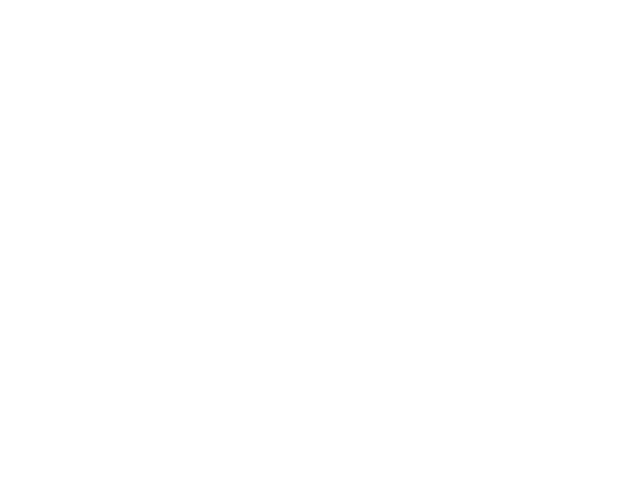

In [23]:

# Set the path to the directory with GeoTiff files
folder_path = 'SAR_amplitude'
filelist = get_filelist(folder_path)

#
timeseries = TimeseriesPlot(filelist)

## Display the map
timeseries.show_map()

## Coherence Plot

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

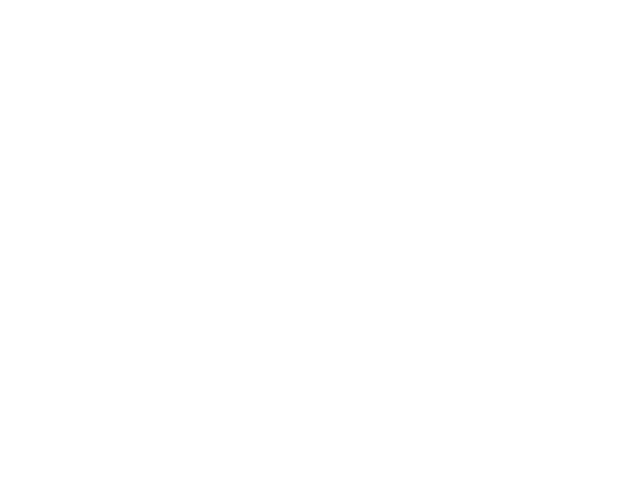

In [24]:

# Set the path to the directory with GeoTiff files
folder_path = '../coherence_time_series/InSAR_coherence'
filelist = get_filelist(folder_path)

#
coherence = CoherencePlot(filelist)

## Display the map
coherence.show_map()

## Save NetCDF files

Convert the Timeseries object to a Xarray.DataArray object and save it to a NetCDF file.

### Timeseries

In [37]:
import xarray as xr

def make_data_array(series_id):
    series = timeseries.extractor.metadata[series_id]['label']
    lat_lon = timeseries.extractor.metadata[series_id]['coordinates']
    description = f'Pixel values extracted at {lat_lon[0]}, {lat_lon[1]}' 
    return xr.DataArray(
        data = timeseries.extractor.data[series],
        #dims=['x', 'y', 'time'],
        dims='time',
        name=series, #timeseries.extractor.shown_series,
        coords=dict(
            time=timeseries.extractor.data['date']
        ),
        attrs=dict(
            description=description,
            longitude=lat_lon[1],
            latitude=lat_lon[0],
            units='uncalibrated'
        )
    )


data_arrays = {
    timeseries.extractor.metadata[series]['label'] : make_data_array(series)
    for series 
    in timeseries.extractor.shown_series
}
    
#for series in timeseries.extractor.shown_series:
#    ds[series] = timeseries.extractor.data[series]
ds = xr.Dataset(
    data_vars=data_arrays,
    attrs = dict(
        description="A time series of InSAR Amplitudes"
    ),
)
ds.to_netcdf('test_timeseries.nc')
ds

<xarray.Dataset>
Dimensions:     (time: 213)
Coordinates:
  * time        (time) datetime64[ns] 2014-10-14 2014-10-26 ... 2024-02-24
Data variables:
    Location 1  (time) float64 1.248e+05 0.0 1.534e+05 ... 2.405e+05 2.683e+05
    Location 2  (time) float64 5.088e+04 0.0 6.334e+04 ... 1.845e+05 1.424e+05
Attributes:
    description:  A time series of InSAR Amplitudes

### Coherence

In [34]:
def make_data_array(series_id):
    series = coherence.extractor.metadata[series_id]['label']
    lat_lon = coherence.extractor.metadata[series_id]['coordinates']
    description = f'Pixel values extracted at {lat_lon[0]}, {lat_lon[1]}' 
    return xr.DataArray(
        data = coherence.extractor.data[series],
        #dims=['x', 'y', 'time'],
        dims=['start_date', 'end_end'],
        name=series, #timeseries.extractor.shown_series,
        coords=dict(
            start_date=coherence.extractor.data['start_date'],
            end_date=coherence.extractor.data['end_date']
        ),
        attrs=dict(
            description=description,
            longitude=lat_lon[1],
            latitude=lat_lon[0],
            units='uncalibrated'
        )
    )


data_arrays = {
    coherence.extractor.metadata[series]['label'] : make_data_array(series)
    for series 
    in coherence.extractor.shown_series
}
    
#for series in timeseries.extractor.shown_series:
#    ds[series] = timeseries.extractor.data[series]
ds = xr.Dataset(
    data_vars=data_arrays,
    attrs = dict(
        description="InSAR Coherence"
    ),
)
ds.to_netcdf('test_coherence.nc')
ds

ValueError: different number of dimensions on data and dims: 1 vs 2

In [31]:
coherence.extractor.data

,filename,start_date,end_date,start_end_date,Location 1
0,20151208_20160313.geo.cc.tif,2015-12-08,2016-03-13,"(2015-12-08 00:00:00, 2016-03-13 00:00:00)",120.0
1,20151208_20160406.geo.cc.tif,2015-12-08,2016-04-06,"(2015-12-08 00:00:00, 2016-04-06 00:00:00)",109.0
2,20151208_20160430.geo.cc.tif,2015-12-08,2016-04-30,"(2015-12-08 00:00:00, 2016-04-30 00:00:00)",75.0
3,20151208_20160524.geo.cc.tif,2015-12-08,2016-05-24,"(2015-12-08 00:00:00, 2016-05-24 00:00:00)",72.0
4,20151208_20160804.geo.cc.tif,2015-12-08,2016-08-04,"(2015-12-08 00:00:00, 2016-08-04 00:00:00)",18.0
...,...,...,...,...,...
1706,20231015_20231108.geo.cc.tif,2023-10-15,2023-11-08,"(2023-10-15 00:00:00, 2023-11-08 00:00:00)",140.0
1707,20231015_20231120.geo.cc.tif,2023-10-15,2023-11-20,"(2023-10-15 00:00:00, 2023-11-20 00:00:00)",146.0
1708,20231027_20231108.geo.cc.tif,2023-10-27,2023-11-08,"(2023-10-27 00:00:00, 2023-11-08 00:00:00)",188.0
1709,20231027_20231120.geo.cc.tif,2023-10-27,2023-11-20,"(2023-10-27 00:00:00, 2023-11-20 00:00:00)",186.0


In [38]:
timeseries.extractor.data

,filename,date,Location 1,Location 2
0,20141014.geo.mli.tif,2014-10-14,124836.484375,50879.437500
1,20141026.geo.mli.tif,2014-10-26,0.000000,0.000000
2,20141107.geo.mli.tif,2014-11-07,153415.109375,63337.835938
3,20141201.geo.mli.tif,2014-12-01,164064.406250,49550.550781
4,20141213.geo.mli.tif,2014-12-13,0.000000,0.000000
...,...,...,...,...
208,20240107.geo.mli.tif,2024-01-07,373507.062500,114821.375000
209,20240119.geo.mli.tif,2024-01-19,0.000000,0.000000
210,20240131.geo.mli.tif,2024-01-31,0.000000,0.000000
211,20240212.geo.mli.tif,2024-02-12,240464.250000,184539.296875


(0.0, 1.0)